# Pairs Selection using Cointegration Tests & Kalman Filter

## Imports & Settings

In [68]:
import os
import sys
import csv
import requests
import io
from collections import Counter
import warnings
from datetime import date
from dataclasses import dataclass, asdict
from time import time
from collections import defaultdict
from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web

from scipy.stats import pearsonr, spearmanr

from pykalman import KalmanFilter

import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.stattools import acf, q_stat, adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR

import backtrader as bt
from backtrader.feeds import PandasData

import pyfolio as pf

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [241]:
warnings.filterwarnings('ignore')
idx = pd.IndexSlice

In [5]:
DATA_PATH = Path('..', 'data') 

In [4]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return f'{h:>02.0f}:{m:>02.0f}:{s:>02.0f}'

### Johansen Test Critical Values

In [6]:
critical_values = {0: {.9: 13.4294, .95: 15.4943, .99: 19.9349},
                   1: {.9: 2.7055, .95: 3.8415, .99: 6.6349}}

In [7]:
trace0_cv = critical_values[0][.95] # critical value for 0 cointegration relationships
trace1_cv = critical_values[1][.95] # critical value for 1 cointegration relationship

## Load Data

### Load Stock Prices

In [200]:
stocks = pd.read_hdf('data.h5', 'stocks/close').loc['2015':]
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2015-01-02 to 2019-12-31
Columns: 168 entries, AA to YUM
dtypes: float64(168)
memory usage: 1.6 MB


### Load ETF Data

In [201]:
etfs = pd.read_hdf('data.h5', 'etfs/close').loc['2015':]
etfs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2015-01-02 to 2019-12-31
Columns: 138 entries, AAXJ to YCS
dtypes: float64(138)
memory usage: 1.3 MB


### Load Ticker Dictionary

In [70]:
def get_ticker_dict():
    sybmols = (pd.read_hdf('data.h5', 'symbols')
               .set_index('symbol')
               .squeeze()
               .to_dict())

In [71]:
names = get_ticker_dict()

## Precompute Cointegration

In [12]:
def test_cointegration(etfs, stocks, test_end, lookback=2):
    start = time()
    results = []
    test_start = test_end - pd.DateOffset(years=lookback) + pd.DateOffset(days=1)
    etf_symbols = etfs.columns.tolist()
    etf_data = etfs.loc[str(test_start):str(test_end)]

    stock_symbols = stocks.columns.tolist()
    stock_data = stocks.loc[str(test_start):str(test_end)]
    j = 0
    for i, s1 in enumerate(etf_symbols, 1):
        for s2 in stock_symbols:
            j += 1
            if j % 1000 == 0:
                print(f'\t{j} | {time() - start:.2f}')
            df = etf_data.loc[:, [s1]].dropna().join(stock_data.loc[:, [s2]].dropna(), how='inner')
            var = VAR(df)
            lags = var.select_order()
            result = [test_end, s1, s2]
            order = lags.selected_orders['aic']
            result += [coint(df[s1], df[s2], trend='c')[1], coint(df[s2], df[s1], trend='c')[1]]

            cj = coint_johansen(df, det_order=0, k_ar_diff=order)
            result += (list(cj.lr1) + list(cj.lr2) + list(cj.evec[:, cj.ind[0]]))
            results.append(result)
    return results

### Define Test Periods

In [202]:
dates = stocks.loc['2016-12':'2019-6'].resample('Q').last().index
dates

DatetimeIndex(['2016-12-31', '2017-03-31', '2017-06-30', '2017-09-30',
               '2017-12-31', '2018-03-31', '2018-06-30', '2018-09-30',
               '2018-12-31', '2019-03-31', '2019-06-30'],
              dtype='datetime64[ns]', name='date', freq='Q-DEC')

### Run Tests

In [ ]:
test_results = []
columns = ['test_end', 's1', 's2', 'eg1', 'eg2',
           'trace0', 'trace1', 'eig0', 'eig1', 'w1', 'w2']

for test_end in dates:
    print(test_end)
    result = test_cointegration(etfs, stocks, test_end=test_end)
    test_results.append(pd.DataFrame(result, columns=columns))

pd.concat(test_results).to_hdf('backtest.h5', 'cointegration_test')

#### Reload  Test Results

In [86]:
test_results = pd.read_hdf('backtest.h5', 'cointegration_test')
test_results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 698895 entries, 0 to 22544
Data columns (total 11 columns):
test_end    698895 non-null datetime64[ns]
s1          698895 non-null object
s2          698895 non-null object
eg1         698895 non-null float64
eg2         698895 non-null float64
trace0      698895 non-null float64
trace1      698895 non-null float64
eig0        698895 non-null float64
eig1        698895 non-null float64
w1          698895 non-null float64
w2          698895 non-null float64
dtypes: datetime64[ns](1), float64(8), object(2)
memory usage: 64.0+ MB


## Identify Cointegrated Pairs

### Significant Johansen Trace Statistic

In [87]:
test_results['joh_sig'] = ((test_results.trace0 > trace0_cv) &
                           (test_results.trace1 > trace1_cv))

In [88]:
test_results.joh_sig.value_counts(normalize=True)

False    0.942174
True     0.057826
Name: joh_sig, dtype: float64

### Significant Engle Granger Test

In [89]:
test_results['eg'] = test_results[['eg1', 'eg2']].min(axis=1)
test_results['s1_dep'] = test_results.eg1 < test_results.eg2
test_results['eg_sig'] = (test_results.eg < .05)

In [90]:
test_results.eg_sig.value_counts(normalize=True)

False    0.889091
True     0.110909
Name: eg_sig, dtype: float64

### Comparison Engle-Granger vs Johansen

In [91]:
test_results['coint'] = (test_results.eg_sig & test_results.joh_sig)
test_results.coint.value_counts(normalize=True)

False    0.981451
True     0.018549
Name: coint, dtype: float64

In [92]:
test_results = test_results.drop(['eg1', 'eg2', 'trace0', 'trace1', 'eig0', 'eig1'], axis=1)
test_results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 698895 entries, 0 to 22544
Data columns (total 10 columns):
test_end    698895 non-null datetime64[ns]
s1          698895 non-null object
s2          698895 non-null object
w1          698895 non-null float64
w2          698895 non-null float64
joh_sig     698895 non-null bool
eg          698895 non-null float64
s1_dep      698895 non-null bool
eg_sig      698895 non-null bool
coint       698895 non-null bool
dtypes: bool(4), datetime64[ns](1), float64(3), object(2)
memory usage: 40.0+ MB


### Comparison

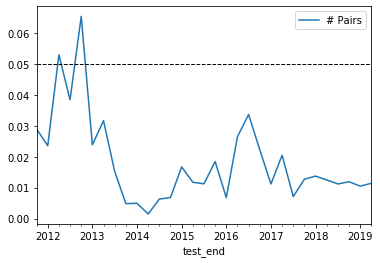

In [93]:
ax = test_results.groupby('test_end').coint.mean().to_frame('# Pairs').plot()
ax.axhline(.05, lw=1, ls='--', c='k');

### Select Candidate Pairs

In [83]:
def select_candidate_pairs(data):
    candidates = data[data.joh_sig | data.eg_sig]
    candidates['y'] = candidates.apply(lambda x: x.s1 if x.s1_dep else x.s2, axis=1)
    candidates['x'] = candidates.apply(lambda x: x.s2 if x.s1_dep else x.s1, axis=1)
    return candidates.drop(['s1_dep', 's1', 's2'], axis=1)

In [ ]:
candidates = select_candidates(test_results)
candidates.to_hdf('backtest.h5', 'candidates')

In [119]:
candidates = pd.read_hdf('backtest.h5', 'candidates')
candidates.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104964 entries, 13 to 22533
Data columns (total 12 columns):
test_end    104964 non-null datetime64[ns]
trace0      104964 non-null float64
trace1      104964 non-null float64
eig0        104964 non-null float64
eig1        104964 non-null float64
w1          104964 non-null float64
w2          104964 non-null float64
joh_sig     104964 non-null bool
eg          104964 non-null float64
eg_sig      104964 non-null bool
y           104964 non-null object
x           104964 non-null object
dtypes: bool(2), datetime64[ns](1), float64(7), object(2)
memory usage: 9.0+ MB


#### # Candidates over Time

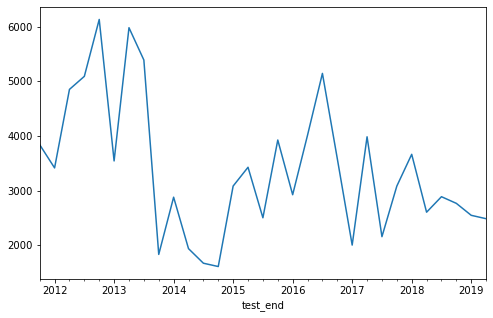

In [120]:
candidates.groupby('test_end').size().plot(figsize=(8,5));

#### Most Common Pairs 

In [225]:
with pd.HDFStore('data.h5') as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: data.h5
/etfs/close              frame        (shape->[2516,138])
/stocks/close            frame        (shape->[2516,168])


In [226]:
with pd.HDFStore('backtest.h5') as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: backtest.h5
/candidates                    frame        (shape->[31764,12]) 
/cointegration_test            frame        (shape->[247995,11])


In [125]:
counter = Counter()
for s1, s2 in zip(candidates[candidates.joh_sig & candidates.eg_sig].y, 
                  candidates[candidates.joh_sig & candidates.eg_sig].x):
    if s1 > s2:
        counter[(s2, s1)] += 1
    else: 
        counter[(s1, s2)] += 1

In [126]:
most_common_pairs = pd.DataFrame(counter.most_common(10))
most_common_pairs = pd.DataFrame(most_common_pairs[0].values.tolist(), columns=['s1', 's2'])
most_common_pairs

,s1,s2
0,ALXN,IYZ
1,DDM,FDX
2,PRU,SHV
3,BA,SHV
4,BIL,KR
5,BAX,SHV
6,SHV,T
7,ADBE,BIL
8,BIL,CRM
9,EEM,KSS


In [163]:
with pd.HDFStore('backtest.h5') as store:
    prices = store['prices'].close.unstack('symbol').ffill(limit=5)
    symbols = store['symbols'].set_index('symbol').squeeze().to_dict()

In [135]:
cnt = pd.Series(counter).reset_index()
cnt.columns = ['s1', 's2', 'n']
cnt['name1'] = cnt.s1.map(names)
cnt['name2'] = cnt.s2.map(names)
cnt.nlargest(10, columns='n')

,s1,s2,n,name1,name2
99,ALXN,IYZ,8,ALEXION PHARMACEUTICALS,ISHARES US TELECOMMUNICATIONS ETF
1871,DDM,FDX,8,PROSHARES ULTRA DOW30,FEDEX
2066,PRU,SHV,8,PRUDENTIAL FINANCIAL,ISHARES SHORT TREASURY BOND ETF
2777,BA,SHV,8,BOEING,ISHARES SHORT TREASURY BOND ETF
12,BIL,KR,7,SPDR BLOOMBERG BARCLAYS 1-3 MONTH T-BILL ETF,KROGER
275,BAX,SHV,7,BAXTER INT,ISHARES SHORT TREASURY BOND ETF
467,SHV,T,7,ISHARES SHORT TREASURY BOND ETF,AT&T
585,ADBE,BIL,7,ADOBE,SPDR BLOOMBERG BARCLAYS 1-3 MONTH T-BILL ETF
587,BIL,CRM,7,SPDR BLOOMBERG BARCLAYS 1-3 MONTH T-BILL ETF,SALESFORCE.COM
1311,EEM,KSS,7,ISHARES MSCI EMERGING MARKETS ETF,KOHL'S


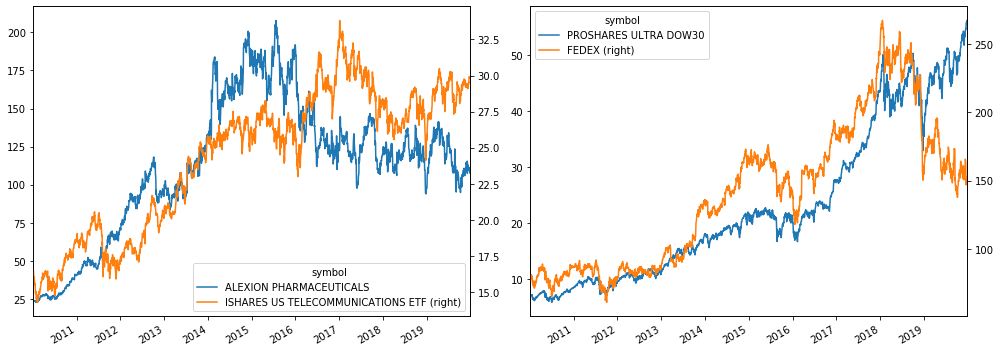

In [136]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
for i in range(2):
    s1, s2 = most_common_pairs.at[i, 's1'], most_common_pairs.at[i, 's2']
    prices.loc[:, [s1, s2]].rename(columns=symbols).plot(secondary_y=symbols[s2], ax=axes[i])
    axes[i].grid(False)
    axes[i].set_xlabel('')
    
fig.tight_layout()
fig.savefig('figures/common_pairs', dpi=300)

## Get Entry and Exit Dates 

### Smooth prices using Kalman filter

In [164]:
def KFSmoother(prices):
    """Estimate rolling mean"""
    
    kf = KalmanFilter(transition_matrices=np.eye(1),
                      observation_matrices=np.eye(1),
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=.05)

    state_means, _ = kf.filter(prices.values)
    return pd.Series(state_means.flatten(),
                     index=prices.index)

In [165]:
smoothed_prices = prices.apply(KFSmoother)
smoothed_prices.to_hdf('tmp.h5', 'smoothed')

In [166]:
smoothed_prices = pd.read_hdf('tmp.h5', 'smoothed')

### Compute rolling hedge ratio using Kalman Filter

In [167]:
def KFHedgeRatio(x, y):
    """Estimate Hedge Ratio"""
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2)
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                      initial_state_mean=[0, 0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=trans_cov)

    state_means, _ = kf.filter(y.values)
    return -state_means

### Estimate mean reversion half life

In [168]:
def estimate_half_life(spread):
    X = spread.shift().iloc[1:].to_frame().assign(const=1)
    y = spread.diff().iloc[1:]
    beta = (np.linalg.inv(X.T@X)@X.T@y).iloc[0]
    halflife = int(round(-np.log(2) / beta, 0))
    return max(halflife, 1)

### Compute Spread & Bollinger Bands

In [174]:
def get_spread(candidates, prices):
    pairs = []
    half_lives = []

    periods = pd.DatetimeIndex(sorted(candidates.test_end.unique()))
    start = time()
    for p, test_end in enumerate(periods, 1):
        start_iteration = time()

        period_candidates = candidates.loc[candidates.test_end == test_end, ['y', 'x']]
        trading_start = test_end + pd.DateOffset(days=1)
        t = trading_start - pd.DateOffset(years=2)
        T = trading_start + pd.DateOffset(months=6) - pd.DateOffset(days=1)
        max_window = len(prices.loc[t: test_end].index)
        period_symbols = period_candidates.y.append(period_candidates.x).unique()
        print(test_end.date(), len(period_candidates))
        for i, (y, x) in enumerate(zip(period_candidates.y, period_candidates.x), 1):
            if i % 1000 == 0:
                msg = f'{i:5.0f} | {time() - start_iteration:7.1f} | {time() - start:10.1f}'
                print(msg)
            pair = prices.loc[t: T, [y, x]]
            pair['hedge_ratio'] = KFHedgeRatio(y=KFSmoother(prices.loc[t: T, y]),
                                               x=KFSmoother(prices.loc[t: T, x]))[:, 0]
            pair['spread'] = pair[y].add(pair[x].mul(pair.hedge_ratio))
            half_life = estimate_half_life(pair.spread.loc[t: test_end])

            spread = pair.spread.rolling(window=min(2 * half_life, max_window))
            pair['z_score'] = pair.spread.sub(spread.mean()).div(spread.std())
            pairs.append(pair.loc[trading_start: T].assign(s1=y, s2=x, period=p, pair=i).drop([x, y], axis=1))

            half_lives.append([test_end, y, x, half_life])
    return pairs, half_lives

In [227]:
candidates = pd.read_hdf('backtest.h5', 'candidates')
candidates.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31764 entries, 13 to 22543
Data columns (total 12 columns):
test_end    31764 non-null datetime64[ns]
trace0      31764 non-null float64
trace1      31764 non-null float64
eig0        31764 non-null float64
eig1        31764 non-null float64
w1          31764 non-null float64
w2          31764 non-null float64
joh_sig     31764 non-null bool
eg          31764 non-null float64
eg_sig      31764 non-null bool
y           31764 non-null object
x           31764 non-null object
dtypes: bool(2), datetime64[ns](1), float64(7), object(2)
memory usage: 2.7+ MB


In [ ]:
pairs, half_lives = get_spread(candidates, smoothed_prices)

### Collect Results

#### Half Lives

In [503]:
hl = pd.DataFrame(half_lives, columns=['test_end', 's1', 's2', 'half_life'])
hl.info()

count    39767.000000
mean        16.985415
std        107.178235
min          1.000000
25%         11.000000
50%         13.000000
75%         16.000000
max      18823.000000
Name: hl, dtype: float64

In [106]:
hl.half_life.describe()

count    104964.000000
mean         14.211892
std           4.594246
min           1.000000
25%          11.000000
50%          13.000000
75%          17.000000
max         111.000000
Name: half_life, dtype: float64

In [105]:
hl.to_hdf('backtest.h5', 'half_lives')

#### Pair Data

In [176]:
pair_data = pd.concat(pairs)
pair_data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13193119 entries, 2012-01-03 to 2019-12-31
Data columns (total 7 columns):
hedge_ratio    13193119 non-null float64
spread         13193119 non-null float64
z_score        13193119 non-null float64
s1             13193119 non-null object
s2             13193119 non-null object
period         13193119 non-null int64
pair           13193119 non-null int64
dtypes: float64(3), int64(2), object(2)
memory usage: 805.2+ MB


In [43]:
pair_data.to_hdf('backtest.h5', 'pair_data')

In [175]:
pair_data = pd.read_hdf('backtest.h5', 'pair_data')

### Identify Long & Short Entry and Exit Dates

In [ ]:
def get_trades(data):
    pair_trades = []
    for i, ((period, s1, s2), pair) in enumerate(data.groupby(['period', 's1', 's2']), 1):
        if i % 100 == 0:
            print(i)

        first3m = pair.first('3M').index
        last3m = pair.last('3M').index

        entry = pair.z_score.abs() > 2
        entry = ((entry.shift() != entry)
                 .mul(np.sign(pair.z_score))
                 .fillna(0)
                 .astype(int)
                 .sub(2))

        exit = (np.sign(pair.z_score.shift().fillna(method='bfill'))
                != np.sign(pair.z_score)).astype(int) - 1

        trades = (entry[entry != -2].append(exit[exit == 0])
                  .to_frame('side')
                  .sort_values(['date', 'side'])
                  .squeeze())
        if not isinstance(trades, pd.Series):
            continue
        try:
            trades.loc[trades < 0] += 2
        except:
            print(type(trades))
            print(trades)
            print(pair.z_score.describe())
            break

        trades = trades[trades.abs().shift() != trades.abs()]
        window = trades.loc[first3m.min():first3m.max()]
        extra = trades.loc[last3m.min():last3m.max()]
        n = len(trades)

        if window.iloc[0] == 0:
            if n > 1:
                print('shift')
                window = window.iloc[1:]
        if window.iloc[-1] != 0:
            extra_exits = extra[extra == 0].head(1)
            if extra_exits.empty:
                continue
            else:
                window = window.append(extra_exits)

        trades = pair[['s1', 's2', 'hedge_ratio', 'period', 'pair']].join(window.to_frame('side'), how='right')
        trades.loc[trades.side == 0, 'hedge_ratio'] = np.nan
        trades.hedge_ratio = trades.hedge_ratio.ffill()
        pair_trades.append(trades)
    return pair_trades

In [507]:
pair_trade_data = pd.concat(pair_trades)
pair_trade_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 224364 entries, 2012-01-02 to 2018-11-21
Data columns (total 6 columns):
s1             224364 non-null object
s2             224364 non-null object
hedge_ratio    224364 non-null float64
period         224364 non-null int64
pair           224364 non-null int64
side           224364 non-null int64
dtypes: float64(1), int64(3), object(2)
memory usage: 12.0+ MB


In [56]:
pair_trade_data.head()

,s1,s2,hedge_ratio,period,pair,side
date,,,,,,
2013-10-01,sk,j6,-0.074105,8,474,1
2013-10-07,sk,j6,-0.074105,8,474,0
2013-11-01,sk,j6,-0.074668,8,474,-1
2013-11-25,sk,j6,-0.074668,8,474,0
2013-12-30,sk,j6,-0.074977,8,474,1


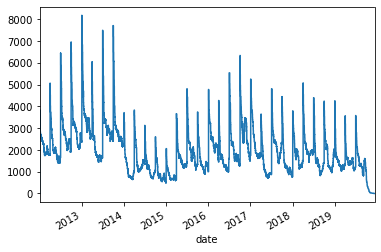

In [193]:
trades = pair_trade_data['side'].copy()
trades.loc[trades!= 0] =1
trades.loc[trades==0] = -1
trades.sort_index().cumsum().plot();

In [508]:
pair_trade_data.to_hdf('backtest.h5', 'pair_trades')